In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from wordcloud import WordCloud

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.feature_extraction.text import CountVectorizer

# Reading Data

In [2]:
df=pd.read_csv("spam.csv", encoding='latin-1')
df.head()

v1                                                 v2 Unnamed: 2  \
0   ham  Go until jurong point, crazy.. Available only ...        NaN   
1   ham                      Ok lar... Joking wif u oni...        NaN   
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...        NaN   
3   ham  U dun say so early hor... U c already then say...        NaN   
4   ham  Nah I don't think he goes to usf, he lives aro...        NaN   

  Unnamed: 3 Unnamed: 4  
0        NaN        NaN  
1        NaN        NaN  
2        NaN        NaN  
3        NaN        NaN  
4        NaN        NaN

#### Columns Meaning
* v1 is our label column. Which represent wether the email is spam or not spam.
* v2 column contains the text of the emails.
* Other columns are not important

#### Dropping the unnecessary columns and rename other

In [3]:
df = df.drop(columns = ['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'])

In [8]:
df = df.rename(columns={'v1' : 'label','v2' : 'message'})

In [9]:
df.head()

label                                            message
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...

# Exploratory Data Analysis (EDA)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5572 non-null   object
 1   message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [10]:
df.describe()

label                 message
count   5572                    5572
unique     2                    5169
top      ham  Sorry, I'll call later
freq    4825                      30

In [20]:
print("Nulll values")
df.isna().sum()

Nulll values


label      0
message    0
dtype: int64

In [17]:
duplicate=df.duplicated().sum()
print("No od duplicate rows in dataset",duplicate)

No od duplicate rows in dataset 403


In [21]:
df.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

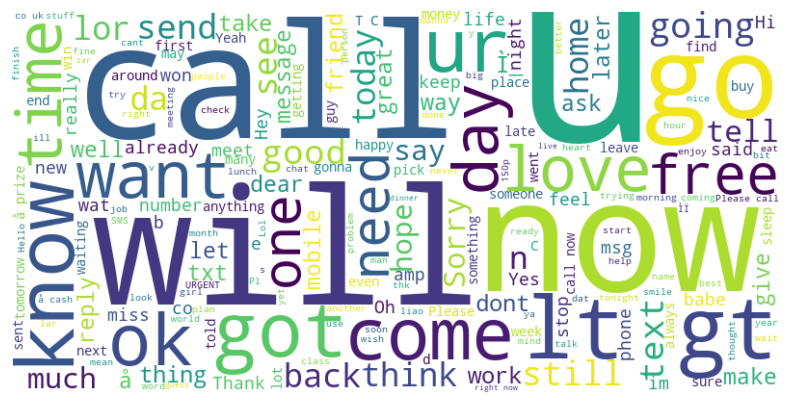

In [22]:
wordcloud = WordCloud(background_color='white', width=800, height=400).generate(''.join(df.message))

plt.figure(figsize=(20, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

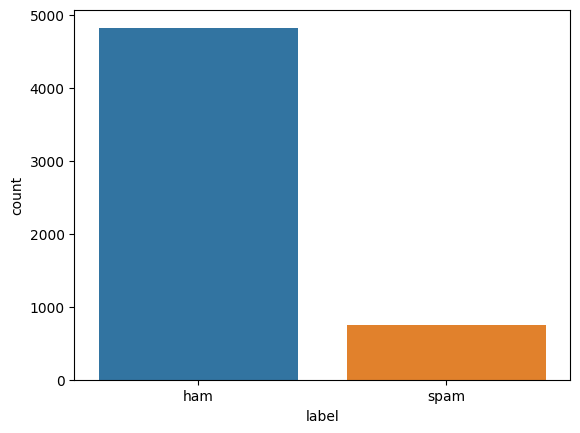

In [24]:
sns.countplot(x = df["label"], data = df)
plt.show()

In [26]:
df['message_len'] = df.message.apply(len)
df.head()

label                                            message  message_len
0   ham  Go until jurong point, crazy.. Available only ...          111
1   ham                      Ok lar... Joking wif u oni...           29
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...          155
3   ham  U dun say so early hor... U c already then say...           49
4   ham  Nah I don't think he goes to usf, he lives aro...           61

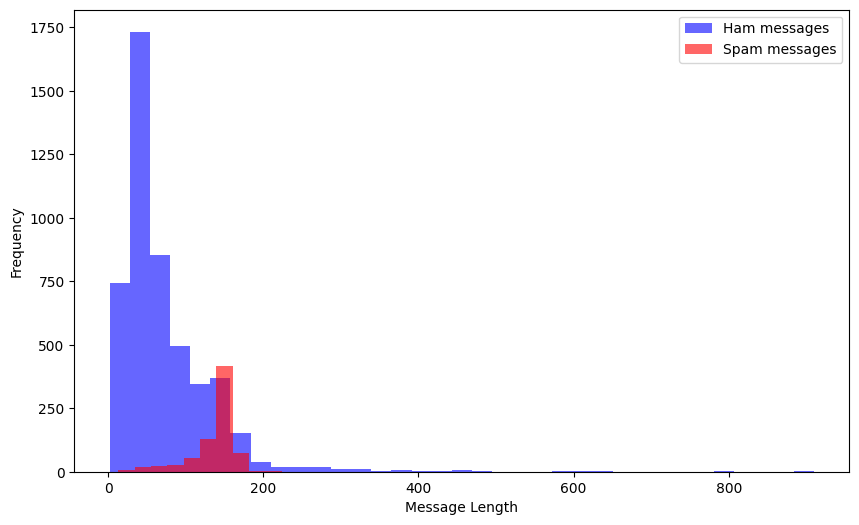

In [30]:
plt.figure(figsize=(10, 6))

df[df.label=='ham'].message_len.plot(bins=35, kind='hist', color='blue', 
                                       label='Ham messages', alpha=0.6)
df[df.label=='spam'].message_len.plot(kind='hist', color='red', 
                                       label='Spam messages', alpha=0.6)
plt.legend()
plt.xlabel("Message Length")
plt.show()

In [31]:
df[df.label=='ham'].describe()

message_len
count  4825.000000
mean     71.023627
std      58.016023
min       2.000000
25%      33.000000
50%      52.000000
75%      92.000000
max     910.000000

In [32]:
df[df.label=='spam'].describe()

message_len
count   747.000000
mean    138.866131
std      29.183082
min      13.000000
25%     132.500000
50%     149.000000
75%     157.000000
max     224.000000

In [33]:
df.drop(columns=['message_len'],inplace=True)

In [34]:
df.head()

label                                            message
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...

#### Handling Imbalance Data

In [38]:
print('imbalance data percentage')
df.label.value_counts()/df.shape[0]*100

imbalance data percentage


ham     86.593683
spam    13.406317
Name: label, dtype: float64

In [40]:
df['label'] = df["label"].map({'spam':1,'ham':0})

In [41]:
df.head()

label                                            message
0      0  Go until jurong point, crazy.. Available only ...
1      0                      Ok lar... Joking wif u oni...
2      1  Free entry in 2 a wkly comp to win FA Cup fina...
3      0  U dun say so early hor... U c already then say...
4      0  Nah I don't think he goes to usf, he lives aro...

#### up-sampling

In [43]:
from sklearn.utils import resample

# create two different dataframe of majority and minority class 

df_majority = df[(df['label'] == 0)] 

df_minority = df[(df['label'] == 1)] 

# upsample minority class
df_minority_upsampled = resample(df_minority, replace = True, n_samples = 4825, random_state = 42) 

    
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])

Balanced data percentage


<AxesSubplot:>

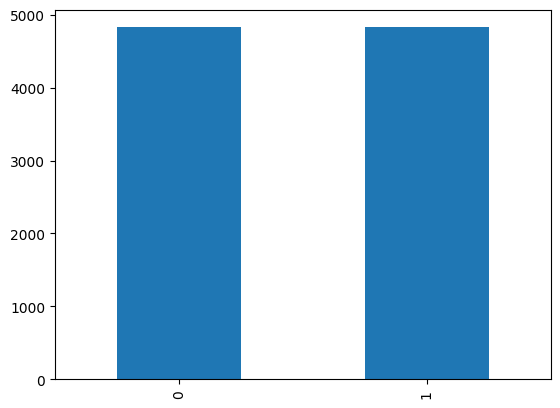

In [48]:
print('Balanced data percentage')
df_upsampled.label.value_counts().plot(kind='bar')

# Modeling

In [49]:
# split X and y into training and testing sets 
from sklearn.model_selection import train_test_split

# how to define X and y (from the SMS data) for use with COUNTVECTORIZER
X = df.message
y = df.label
print(X.shape)
print(y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(5572,)
(5572,)
(4179,)
(1393,)
(4179,)
(1393,)


#### CountVectorizer

In [50]:
from sklearn.feature_extraction.text import CountVectorizer

# instantiate the vectorizer
vect = CountVectorizer(stop_words='english')
vect.fit(X_train)

# learn training data vocabulary, then use it to create a document-term matrix
X_train_dtm = vect.transform(X_train)

# equivalently: combine fit and transform into a single step
X_train_dtm = vect.fit_transform(X_train)


# examine the document-term matrix
print(type(X_train_dtm), X_train_dtm.shape)

# transform testing data (using fitted vocabulary) into a document-term matrix
X_test_dtm = vect.transform(X_test)
print(type(X_test_dtm), X_test_dtm.shape)

<class 'scipy.sparse.csr.csr_matrix'> (4179, 7233)
<class 'scipy.sparse.csr.csr_matrix'> (1393, 7233)


#### Tfidf Transformer

In [51]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer()
tfidf_transformer.fit(X_train_dtm)
tfidf_transformer.transform(X_train_dtm)

<4179x7233 sparse matrix of type '<class 'numpy.float64'>'
	with 32641 stored elements in Compressed Sparse Row format>

## Naive Bayes

In [52]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(X_train_dtm, y_train)
y_pred_nb = nb.predict(X_test_dtm)

# calculate accuracy of class predictions
print("=======Accuracy Score===========")
print(metrics.accuracy_score(y_test, y_pred_nb))

# print the confusion matrix
print("=======Confision Matrix===========")
metrics.confusion_matrix(y_test, y_pred_nb)

=======Accuracy Score===========
0.9892318736539842
=======Confision Matrix===========


array([[1208,    5],
       [  10,  170]], dtype=int64)

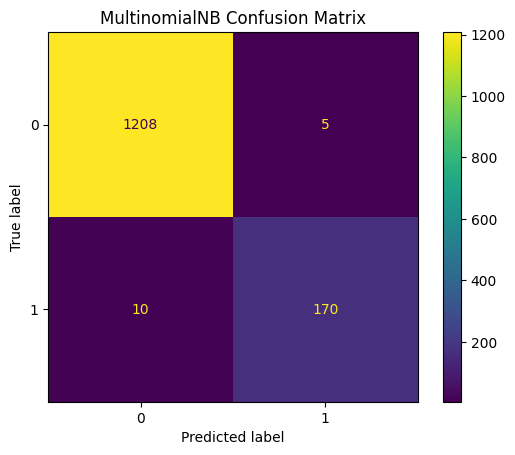

In [57]:
cm   = metrics.confusion_matrix(y_test, y_pred_nb, labels=nb.classes_)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=nb.classes_)
disp.plot()
plt.title('MultinomialNB Confusion Matrix')
plt.show()

## Logistic Regression

In [59]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(X_train_dtm, y_train)
y_pred_lr = lr.predict(X_test_dtm)

# calculate accuracy of class predictions
print("=======Accuracy Score===========")
print(metrics.accuracy_score(y_test, y_pred_lr))

# print the confusion matrix
print("=======Confision Matrix===========")
metrics.confusion_matrix(y_test, y_pred_lr)

=======Accuracy Score===========
0.9856424982053122
=======Confision Matrix===========


array([[1213,    0],
       [  20,  160]], dtype=int64)

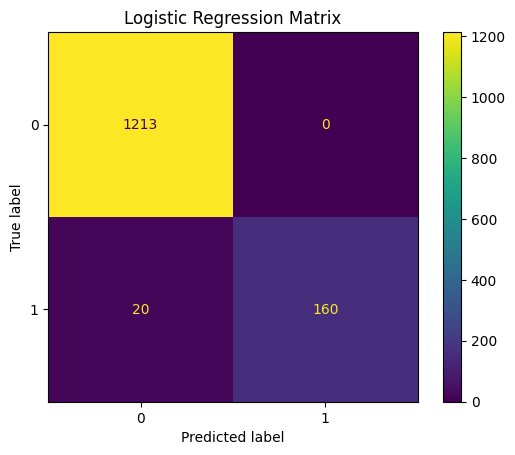

In [60]:
cm   = metrics.confusion_matrix(y_test, y_pred_lr, labels=lr.classes_)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr.classes_)
disp.plot()
plt.title('Logistic Regression Matrix')
plt.show()

## Support Vector Classification

In [62]:
from sklearn.svm import SVC

svc = SVC()
svc.fit(X_train_dtm, y_train)
y_pred_svc = svc.predict(X_test_dtm)

# calculate accuracy of class predictions
print("=======Accuracy Score===========")
print(metrics.accuracy_score(y_test, y_pred_svc))

# print the confusion matrix
print("=======Confision Matrix===========")
metrics.confusion_matrix(y_test, y_pred_svc)

=======Accuracy Score===========
0.9842067480258435
=======Confision Matrix===========


array([[1213,    0],
       [  22,  158]], dtype=int64)

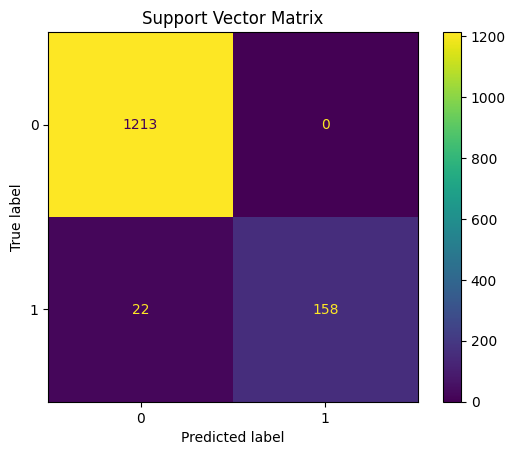

In [63]:
cm   = metrics.confusion_matrix(y_test, y_pred_svc, labels=svc.classes_)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svc.classes_)
disp.plot()
plt.title('Support Vector Matrix')
plt.show()